## Image segmentation with fastai

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

In [3]:
path = os.getcwd()
img_path = path+'/data/h5/sem_seg'
path_img = img_path+'/new'
path_lbl = path+'/data/h5/good_masks/bld'

## Data

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/georg/fyp/data/h5/sem_seg/new/9143200_5814800.png'),
 WindowsPath('C:/Users/georg/fyp/data/h5/sem_seg/new/9143200_5820000.png'),
 WindowsPath('C:/Users/georg/fyp/data/h5/sem_seg/new/9143200_5820400.png')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/georg/fyp/data/h5/good_masks/bld/mask_building_9143200_5814800.tif'),
 WindowsPath('C:/Users/georg/fyp/data/h5/good_masks/bld/mask_building_9143200_5820000.tif'),
 WindowsPath('C:/Users/georg/fyp/data/h5/good_masks/bld/mask_building_9143200_5820400.tif')]

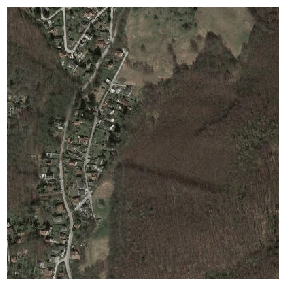

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: path_lbl+f'/mask_building_{x.stem}.tif'

In [8]:
lbl_names[1]

WindowsPath('C:/Users/georg/fyp/data/h5/good_masks/bld/mask_building_9143200_5820000.tif')

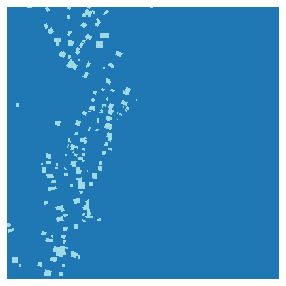

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([400, 400]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
codes = array(['Background' , 'Building'])

In [18]:
codes

array(['Background', 'Building'], dtype='<U10')

In [15]:
mask.data.sum()

tensor(5260)

## Datasets

In [16]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 4021MB of GPU RAM free


In [17]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [13]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

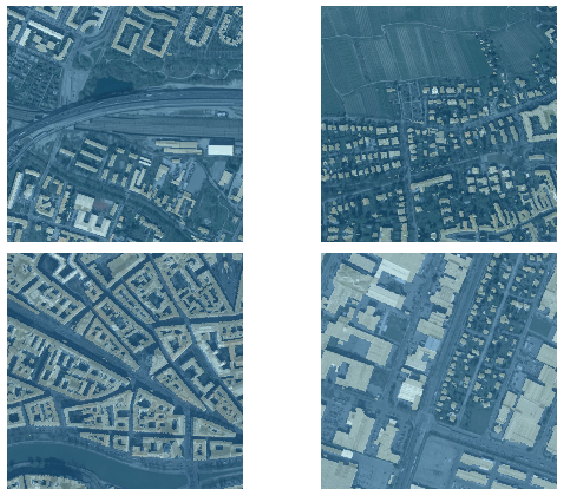

In [14]:
data.show_batch(2, figsize=(10,7))

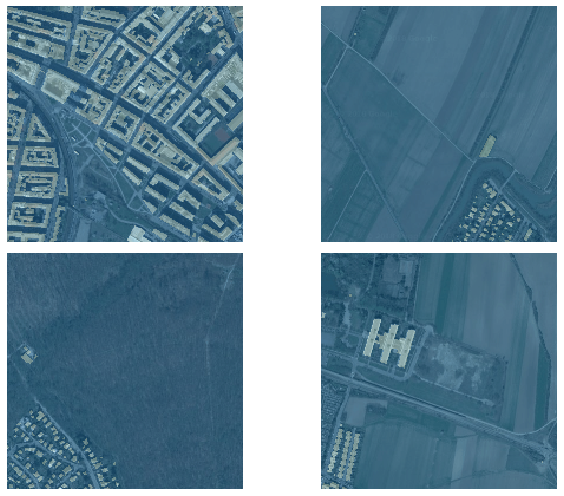

In [15]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [16]:
metrics=accuracy

In [17]:
wd=1e-2

In [18]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


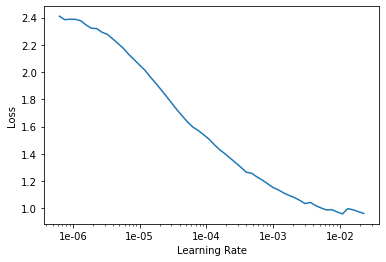

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr=3e-3

In [21]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: The size of tensor a (400) must match the size of tensor b (40000) at non-singleton dimension 1

In [ ]:
print

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.389135,0.334715,0.896700
2,0.377873,0.324080,0.900284
3,0.369020,0.325073,0.904146
4,0.355022,0.308820,0.912556
5,0.351138,0.313001,0.909351
6,0.347777,0.285509,0.920183
7,0.338683,0.306076,0.909899
8,0.318913,0.303712,0.915792
9,0.312038,0.276126,0.920137
10,0.311217,0.276649,0.925244


In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


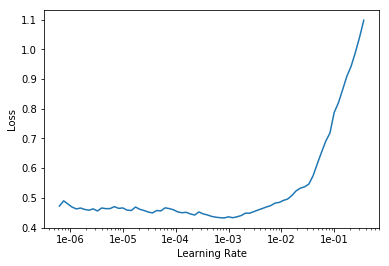

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

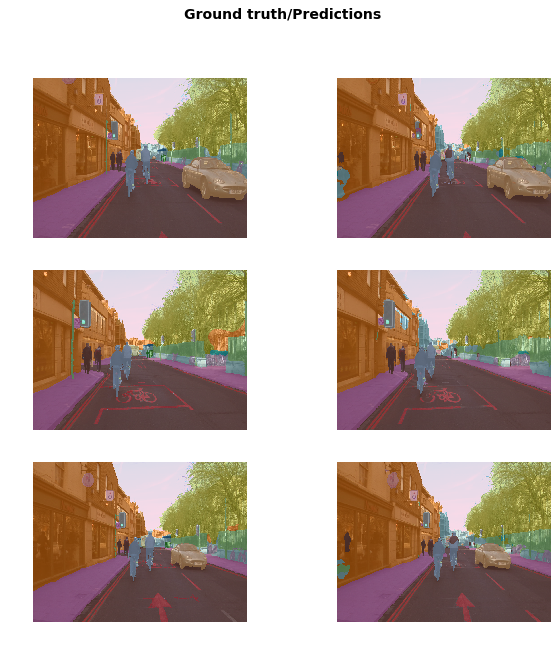

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin